In [30]:
import torch
import torch.nn as nn
import numpy as np


class Agent(nn.Module):
    def __init__(self,id,num_channels, on_off_rate = 1):
        print("agent made")
        super().__init__()
        self.on_off_rate = on_off_rate
        self.register_parameter(f'S_{id}',nn.Parameter(torch.ones(num_channels) * 6.9))
        _,S = next(self.named_parameters())
        p = nn.Sigmoid()(S.expand(1,num_channels))
        self.A = torch.bernoulli(p) # Actions
        self.Pi = torch.Tensor(self.A.shape) # policy probability
        self.Pi[self.A==1] = p[self.A==1]
        self.Pi[self.A==0] = 1 - p[self.A==0]
        self.R = torch.sum(abs(self.on_off_rate - self.A),dim=1) # Reward

    def forward(self,I):
        #print("agent forward")

        N,c,h,w = I.shape
        _,S = next(self.named_parameters())

        p = nn.Sigmoid()(S.expand(N,c))
        if self.training:
            self.A = torch.bernoulli(p)
        else:
            self.A = self.A.detach()
        self.Pi = torch.Tensor(self.A.shape).to(S.device)
        self.Pi[self.A==1] = p[self.A==1]
        self.Pi[self.A==0] = 1 - p[self.A==0]
        self.R = torch.sum(abs(self.on_off_rate - self.A),dim=1)
        return I*self.A.view(N,c,1,1).contiguous().expand(N,c,h,w)

    def count_active_channels(self):
        """ 현재 활성화된 채널 수를 반환 """

        return torch.sum(self.A[-1]).item()

    def count_all_channels(self):
        """ 모든 채널 수를 반환 """

        return self.A[-1].numel()


class DECOR(nn.Module):
    def __init__(self, Model):
        super().__init__()
        self.target_model = Model
        self.agents_list = [] # To keep track of all newly added agents
        self.parse_model()
        self.agents = nn.ModuleList(self.agents_list)

    def parse_model(self):
        """ This method parse the target model and append agents after the activation function of each convolution, the dictionary of the
            target model should be defined for easy parsing """
        n = ''
        modules = torch.nn.Sequential()
        modules_list = [nn.Conv2d]
        for i in self.target_model.state_dict().keys():
            if n != i.split('.')[0]:
                n = i.split('.')[0]
                a = getattr(self.target_model,f'{n}')
                if hasattr(a, '__iter__'):
                    modules = torch.nn.Sequential()
                    for idx in range(0,len(a)):
                        if type(a[idx]) in modules_list and type(a[idx+1]) == nn.BatchNorm2d and type(a[idx+2]) == nn.ReLU:
                            c = next(a[idx].parameters()).shape[0]
                            # a[idx].requires_grad = False
                            # a[idx+1].requires_grad = False
                            # a[idx+2].requires_grad = False
                            modules.add_module(f'{idx}',a[idx])
                            modules.add_module(f'{idx+1}',a[idx+1])
                            modules.add_module(f'{idx+2}',a[idx+2])
                            agnt = Agent(len(self.agents_list),c)
                            modules.add_module(f'Agent{len(self.agents_list)}',agnt)
                            self.agents_list.append(agnt)
                            idx += 4
                        else:
                            #TODO: frozen layer
                            modules.add_module(f'{idx}',a[idx])

                    a = modules
                    setattr(self.target_model,f'{n}',a)

    def forward(self,I):
        return self.target_model(I)

    def frozen_agent(self, is_fronzen=True):
        for agent in self.agents_list:
            for name, param in agent.named_parameters():
                param.requires_grad = not is_fronzen

    def count_total_active_channels(self):
        """ 모든 에이전트에서 활성화된 채널 수의 총합을 반환 """
        total_active_channels = sum(agent.count_active_channels() for agent in self.agents)
        return total_active_channels

    def count_total_all_channels(self):
        """ 모든 에이전트에서 모든 채널 수의 총합을 반환 """
        #print('agent총 수 : ', len(self.agents))
        total_channels = sum(agent.count_all_channels() for agent in self.agents)
        return total_channels

    def print_active_channel(self):
        """각 에이전트의 활성화된 채널 수 출력"""
        for index, agent in enumerate(self.agents, 1):
            #print(f"Agent {index} 상태 - A: {agent.A[0]}")  # A 벡터 출력
            active_channels = agent.count_active_channels()
            print(f"CNN Layer #{index} Active Channels: {active_channels} / All Channels: {agent.count_all_channels()}")



In [2]:
## custom loss
class CustomLoss(nn.Module):
    def __init__(self, reward, penalty):
        super().__init__()
        self.reward = reward
        self.penalty = penalty # How much to penalize incorrect drop

    def forward(self, agents_list, y_predicted, target):
        loss = 0.0
        N,_ = y_predicted.size()
        y_predicted = y_predicted.argmax(axis = 1)
        t = torch.Tensor(y_predicted.shape).to(y_predicted.device)
        t[y_predicted==target] = self.reward
        t[y_predicted!=target] = self.penalty
        # print(t)
        for a in agents_list:
            R = a.R*t
            loss += torch.mean(torch.sum(torch.log(a.Pi),dim=1)* R)
        return -loss # The aim is to maximize rewards

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Matching active channel indices in the flattened output
def get_flatten_indices(active_channels, height, width):
    flattened_indices = []
    for channel in active_channels:
        # Calculate indices for each active channel, taking height * width for each
        start_idx = int(channel) * height * width
        end_idx = start_idx + height * width
        flattened_indices.extend(range(start_idx, end_idx))
    return flattened_indices

class ModifiedVGG16(nn.Module):
    def __init__(self, vgg16, active_channels_list):
        super(ModifiedVGG16, self).__init__()
        self.features = None
        self.classifier = None
        self.avgpool = None
        self.active_channels_list = active_channels_list

        conv_layer_count = 0
        prev_out_channels = 3
        vgg16.eval()

        feature_class = True
        for i, layer in enumerate(vgg16.children()):
            print('i layer : ', type(layer))
            if isinstance(layer, nn.Sequential) and feature_class:
                new_seq_layers = []
                # Sequential 내부의 Conv2d 레이어 탐색
                j = 0
                while j < len(layer):
                    sub_layer = layer[j]
                    if type(sub_layer) == nn.Conv2d and type(layer[j+1]) == nn.BatchNorm2d and type(layer[j+2]) == nn.ReLU:
                        print(' j : ', j, type(sub_layer), ' conv2d?')
                        #print(sub_layer)
                        # 현재 레이어의 활성화된 출력 채널

                        #agent_layer = layer[j+3].eval()


                        active_out_channels = torch.tensor(self.active_channels_list[conv_layer_count], dtype=torch.bool)
                            #agent_layer_active = torch.tensor(agent_layer.A, dtype=torch.bool)

                            # assert torch.equal(active_out_channels.to(device),agent_layer_active[0]), \
                            #     f"active mismatch: {active_out_channels} vs {agent_layer_active[0]}"
                        #print('active_out_channels ' , active_out_channels)

                        # 이전 레이어의 활성화된 입력 채널
                        if conv_layer_count > 0:
                            active_in_channels = torch.tensor(self.active_channels_list[conv_layer_count - 1], dtype=torch.bool)
                            #print('active_in_channels ',  active_in_channels)
                        else:
                            active_in_channels = torch.ones(prev_out_channels, dtype=torch.bool)
                            #print('active_in_channels ',  active_in_channels)

                        #print("bias : ", sub_layer.bias)


                        new_conv = nn.Conv2d(in_channels=active_in_channels.sum().item(),
                            out_channels=active_out_channels.sum().item(),
                            kernel_size=sub_layer.kernel_size,
                            stride=sub_layer.stride,
                            padding=sub_layer.padding,
                            dilation=sub_layer.dilation,
                            groups=sub_layer.groups,
                            bias=True)

                        # 기존 가중치에서 활성화된 출력 채널에 해당하는 가중치만 가져오기
                        out_indices = active_out_channels.nonzero().squeeze(1)
                        in_indices = active_in_channels.nonzero().squeeze(1)
                        # 가중치 복사
                        #out_indices = active_out_channels.nonzero(as_tuple=True)[0]
                        print('out_indices ',  out_indices)
                        #in_indices = active_in_channels.nonzero(as_tuple=True)[0]
                        print('in_indices ',  in_indices)
                        new_bn = nn.BatchNorm2d(len(out_indices), eps=layer[j+1].eps, momentum=layer[j+1].momentum, affine=layer[j+1].affine, track_running_stats=layer[j+1].track_running_stats)
                        # 활성화된 채널만 가져와서 새로운 레이어에 가중치 할당
                        with torch.no_grad():
                            # 가중치와 모ag양이 일치하는지 확인
                            # copied_weights = sub_layer.weight.data[out_indices][:, in_indices]
                            # assert copied_weights.shape == new_conv.weight.data.shape, \
                            #     f"Weight shape mismatch: {copied_weights.shape} vs {new_conv.weight.data.shape}"
                            # new_conv.weight.data[:] = copied_weights.clone()
                            # new_conv.bias.data[:] = sub_layer.bias.data[out_indices].clone()
                            #new_conv.bias.data.copy_(sub_layer.bias.data[out_indices])

                            copied_weights = sub_layer.weight.data[out_indices][:, in_indices]
                            assert copied_weights.shape == new_conv.weight.data.shape, \
                                f"Weight shape mismatch: {copied_weights.shape} vs {new_conv.weight.data.shape}"
                            new_conv.weight.data.copy_(copied_weights)
                            new_conv.bias.data.copy_(sub_layer.bias.data[out_indices])
                            new_seq_layers.append(new_conv)
                            conv_layer_count += 1
                            prev_out_channels = int(sum(active_out_channels))
                            #BatchNorm2D넣기


                            new_bn.weight.data.copy_(layer[j+1].weight.data[out_indices])
                            new_bn.weight.requires_grad = layer[j+1].weight.requires_grad
                            new_bn.bias.data.copy_(layer[j+1].bias.data[out_indices])
                            new_bn.bias.requires_grad = layer[j+1].bias.requires_grad
                            if layer[j+1].track_running_stats:
                                new_bn.running_mean.copy_(layer[j+1].running_mean[out_indices])
                                new_bn.running_var.copy_(layer[j+1].running_var[out_indices])
                                #new_bn.running_var.requires_grad = layer[j+1].running_var[out_indices].requrires_grad
                            new_seq_layers.append(new_bn)
                            #Relu 넣기 ReLU
                            #relu = nn.ReLU(inplace=True)
                            new_seq_layers.append(layer[j+2])


                        # if j == 52:
                        #    new_seq_layers.append(agent_layer)
                        j += 4
                    elif type(sub_layer) == nn.MaxPool2d: # MaxPool2d
                        new_seq_layers.append(sub_layer)
                        j += 1
                    else:
                        j += 1
                self.features = nn.Sequential(*new_seq_layers)
                feature_class = False

            else:
                #(avgpool): AdaptiveAvgPool2d(output_size=(7, 7), (classifier): Sequential,
                if isinstance(layer, nn.AdaptiveAvgPool2d):
                    self.avgpool = layer
                else:
                    flattened_size = 1 * 1 * prev_out_channels

                    active_channel_index = np.where(self.active_channels_list[conv_layer_count - 1] == 1)[0]
                    assert len(active_channel_index) == sum(self.active_channels_list[conv_layer_count - 1]), \
                    "Mismatch in active channels"
                    flatten_indices = get_flatten_indices(active_channel_index, 1, 1)

                    linear = nn.Linear(flattened_size, 4096)
                    with torch.no_grad():
                        # 가중치 복사 및 모양 일치 확인
                        copied_weights = layer[0].weight.data[:, flatten_indices]
                        assert copied_weights.shape == linear.weight.data.shape, \
                            f"Weight shape mismatch: {copied_weights.shape} vs {linear.weight.data.shape}"
                        linear.weight.data.copy_(copied_weights)
                        linear.bias.data.copy_(layer[0].bias.data)
                    self.classifier=nn.Sequential(
                        linear,
                        #layer[0],
                        layer[1],
                        layer[2],
                        layer[3],
                        layer[4],
                        layer[5],
                        layer[6]
                    )


    def forward(self, x):
        x = self.features(x)  # Convolutional layers
        x = self.avgpool(x)  # Adaptive average pooling
        x = torch.flatten(x, -3)  # Flatten for the classifier
        x = self.classifier(x)  # Fully connected layers

        return x


In [4]:
import torchvision
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./__data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./__data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Extracting ./__data/cifar-10-python.tar.gz to ./__data
Files already downloaded and verified


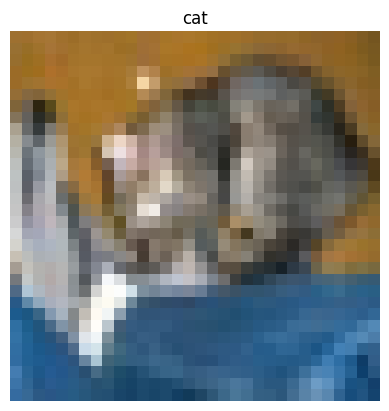

In [5]:
import matplotlib.pyplot as plt

# 이미지와 라벨 하나 가져오기
image, label = testset[0]

# 이미지 원래 범위로 복원 (정규화 해제)
image = image * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)

# 이미지 출력
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[label])
plt.axis('off')
plt.show()

In [6]:
!pip install torchmetrics

from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

metric_collection = MetricCollection([
    MulticlassAccuracy(num_classes=10, average="micro"),
    MulticlassPrecision(num_classes=10, average="macro"),
    MulticlassRecall(num_classes=10, average="macro")
])

def get_metrics(device, model, test_loader):
  with torch.no_grad():
    model.to(device)
    model.eval()
    for x, y in test_loader:
      x = x.to(device)
      y = y
      outputs = model(x)
      _, predicted = outputs.max(1)
      metric_collection.update(predicted.cpu(), y)

  metric_output = metric_collection.compute()

  #print(metric_output)

  acc, precision, recall = metric_output['MulticlassAccuracy'], metric_output['MulticlassPrecision'], metric_output['MulticlassRecall']
  metric_collection.reset()

  return acc, precision, recall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 21.2 MB/s eta 0:00:00


In [7]:
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Import a pre-trained VGG16 and replace classification layer with new layer that has number of classes in CIFAR-10
vgg16 = models.vgg16_bn(weights='IMAGENET1K_V1')
input_lastLayer = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(input_lastLayer,10)
vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
vgg16.classifier[0] = nn.Linear(512, 4096)
model = vgg16.to(device)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 75.7MB/s]


In [8]:
import torch.optim as optim
from google.colab import drive
# import torch.optim as optim
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import torch.optim as optim
# from google.colab import drive
# import torch.optim as optim
# drive.mount('/content/drive')

# model = torch.load('/content/drive/MyDrive/decore_model/vgg_model_bn.pth')

import gc
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_epochs = 1
lr = 0.01
net = DECOR(model)
net = net.to(device)

id = 0
param = []

for n,p in net.named_parameters():
    if n.endswith(f".S_{id}") and p.requires_grad:
        param.append(p)
        id += 1

#optimizer = Adam(param, lr=lr)

optimizer = optim.Adam(net.agents.parameters(), lr=lr) # 이거로 변경해보기
#optimizer = torch.optim.SGD(net.agents.parameters(), lr = lr, momentum=0.9,weight_decay=5e-4)
# optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.SGD(net.agents.parameters(), lr = lr)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,60,80], gamma=0.5)
criterion_decore = CustomLoss(1, -10)
print(f'penalty: {criterion_decore.penalty}')



n_total_step = len(trainloader)

import gc
import time

torch.set_printoptions(edgeitems=torch.inf)
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())
print("decore training start")
# 학습 시작 시간 기록
start_time = time.time()
net.train()
for epoch in range(num_epochs):
    running_corrects = 0 # Accuracy calculation
    total_samples = 0 # Accuracy calculation
    total_loss = 0
    total_all_channel = 0
    total_active_channel = 0
    #train_loss = 0.0
    for i, (imgs , labels) in enumerate(trainloader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        labels_hat = net.target_model(imgs)
        loss_value = criterion_decore(net.agents_list,labels_hat, labels)

        _, preds = torch.max(labels_hat, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

        total_loss += loss_value
        total_all_channel += net.count_total_all_channels()
        total_active_channel += net.count_total_active_channels()

        if (i + 1) % 250 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step: {i+1}/{n_total_step}: loss = {total_loss:.5f}, acc = {(100 * running_corrects / total_samples):.2f}%, channel = { total_active_channel / total_all_channel * 100:.2f}%, lr ={optimizer.param_groups[0]["lr"]} ')
            if 0:
                for agent in net.agents_list:
                    rounded_Pi = torch.round(agent.Pi * 10000) / 10000
                    unique_values, counts = torch.unique(rounded_Pi, return_counts=True)
                    #print(agent.Pi[agent.Pi != 0.999])
                    for value, count in zip(unique_values, counts):
                        print(f"Value: {value.item():.5f}, Count: {count.item()}")
                    break
                total_loss = 0

        #train_loss += loss_value.detach().cpu().item() / len(train_loader)
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        #scheduler.step()



# DECORE 모델에서 활성화된 채널 정보 가져오기
net.eval() # 베르누이 확률 분포에 의해 eval모드가 아니면 값이 변경됨


active_channels_list = []
for agent in net.agents:
    agent.eval()
    # 각 agent에서 활성화된 채널의 인덱스 가져오기 (1차원으로 추출)
    active_channels_list.append(agent.A[-1].detach().cpu().numpy())

for i, (agent, active_channels) in enumerate(zip(net.agents, active_channels_list)):
    print(f"Layer {i} - Agent Active Channels: {agent.count_active_channels()}, "
          f"List Active Channels: {sum(active_channels)}")

for i, active_channels in enumerate(active_channels_list):
    print(f"Layer {i} active channels: {sum(active_channels)} / {active_channels.shape}")

# 학습 종료 시간 기록
end_time = time.time()

# 총 학습 시간 계산
total_time = end_time - start_time
print(f"decore 모델 학습 시간: {total_time // 60:.0f}분 {total_time % 60:.0f}초")
print("총 채널 수 : ", net.eval().count_total_all_channels())
print("활성화된 채널 수 : ",net.eval().count_total_active_channels())


accuracy, precision, recall = get_metrics(device, net.target_model.eval(), testloader)

print ('decore accuracy : ', accuracy, ', precision : ', precision, ', recall : ', recall)


# DECORE 모델에서 활성화된 채널 정보 가져오기
net.eval().print_active_channel()

# Google Drive에 모델 가중치 저장
torch.save(net.state_dict(), '/content/drive/MyDrive/decore_model/decore_vgg_bn_model_weights.pth')

# 전체 모델 저장
torch.save(net, '/content/drive/MyDrive/decore_model/decore_vgg_bn_model.pth')


(15574564864, 15835660288)
cuda:0
agent made
agent made
agent made
agent made
agent made
agent made
agent made
agent made
agent made
agent made
agent made
agent made
agent made
penalty: -10
(15574564864, 15835660288)
decore training start
epoch 1/1, step: 250/500: loss = -86809.42969, acc = 9.65%, channel = 99.91%, lr =0.01 
epoch 1/1, step: 500/500: loss = -143565.76562, acc = 9.61%, channel = 99.93%, lr =0.01 
Layer 0 - Agent Active Channels: 64.0, List Active Channels: 64.0
Layer 1 - Agent Active Channels: 64.0, List Active Channels: 64.0
Layer 2 - Agent Active Channels: 128.0, List Active Channels: 128.0
Layer 3 - Agent Active Channels: 128.0, List Active Channels: 128.0
Layer 4 - Agent Active Channels: 256.0, List Active Channels: 256.0
Layer 5 - Agent Active Channels: 256.0, List Active Channels: 256.0
Layer 6 - Agent Active Channels: 256.0, List Active Channels: 256.0
Layer 7 - Agent Active Channels: 512.0, List Active Channels: 512.0
Layer 8 - Agent Active Channels: 512.0, List

In [10]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (Agent0): Agent()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (Agent1): Agent()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (Agent2): Agent()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (Agent3): Agent()
    (13): MaxPool2d(ke

In [11]:
print(net.target_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (Agent0): Agent()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (Agent1): Agent()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (Agent2): Agent()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (Agent3): Agent()
    (13): MaxPool2d(ke

In [12]:
import torch.nn as nn


class ModifiedVGG16Test(nn.Module):
    def __init__(self, vgg16, active_channels_list):
        super(ModifiedVGG16Test, self).__init__()
        self.features = None
        self.classifier = None
        self.avgpool = None
        self.active_channels_list = active_channels_list

        conv_layer_count = 0
        prev_out_channels = 3
        vgg16.eval()

        feature_class = True
        for i, layer in enumerate(vgg16.children()):
            #print('i layer : ', type(layer))
            if isinstance(layer, nn.Sequential) and feature_class:
                new_seq_layers = []
                # Sequential 내부의 Conv2d 레이어 탐색
                j = 0
                while j < len(layer):
                    sub_layer = layer[j]
                    if type(sub_layer) == nn.Conv2d and type(layer[j+1]) == nn.BatchNorm2d and type(layer[j+2]) == nn.ReLU:
                        #print(type(sub_layer), ' conv2d?')
                        #print(sub_layer)
                        # 현재 레이어의 활성화된 출력 채널
                        new_conv = sub_layer
                        new_seq_layers.append(new_conv)


                        new_bn = nn.BatchNorm2d(layer[j+1].num_features, eps=layer[j+1].eps, momentum=layer[j+1].momentum, affine=layer[j+1].affine, track_running_stats=layer[j+1].track_running_stats)
                        new_bn.weight.data.copy_(layer[j+1].weight.data)
                        new_bn.bias.data.copy_(layer[j+1].bias.data)
                        if layer[j+1].track_running_stats:
                            new_bn.running_mean.copy_(layer[j+1].running_mean)
                            new_bn.running_var.copy_(layer[j+1].running_var)
                        new_seq_layers.append(new_bn)

                        # new_bn = layer[j+1]
                        # new_seq_layers.append(new_bn)

                        #Relu 넣기 ReLU
                        relu = nn.ReLU(inplace=True)
                        new_seq_layers.append(relu)

                        j += 3
                    elif type(sub_layer) == nn.MaxPool2d: # MaxPool2d
                        new_seq_layers.append(sub_layer)
                        j += 1
                    else:# Agent
                        new_seq_layers.append(sub_layer)
                        j += 1
                self.features = nn.Sequential(*new_seq_layers)
                feature_class = False

                #print("conv_layer_count ", conv_layer_count)
            else:
                #(avgpool): AdaptiveAvgPool2d(output_size=(7, 7), (classifier): Sequential,
                if isinstance(layer, nn.AdaptiveAvgPool2d):
                    self.avgpool = layer
                else:

                    self.classifier=layer


    def forward(self, x):
        x = self.features(x)  # Convolutional layers
        x = self.avgpool(x)  # Adaptive average pooling
        x = torch.flatten(x, -3)  # Flatten for the classifier
        x = self.classifier(x)  # Fully connected layers

        return x

In [13]:
from torchvision import models


def pruning_vgg_model(target_path):
	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
	print(device)

	#net = torch.load("decore_vgg_model.pth")
	net = torch.load("/content/drive/MyDrive/decore_model/decore_vgg_bn_model.pth")
	net = net.to(device)
	#print(model)
	net.eval()
	net.target_model.eval()

	active_channels_list = []
	for agent in net.agents:
		agent.eval()
		# 각 agent에서 활성화된 채널의 인덱스 가져오기 (1차원으로 추출)
		active_channels_list.append(agent.A[-1].detach().cpu().numpy())

	for i, (agent, active_channels) in enumerate(zip(net.agents, active_channels_list)):
		print(f"Layer {i} - Agent Active Channels: {agent.count_active_channels()}, "
			f"List Active Channels: {sum(active_channels)}")

	for i, active_channels in enumerate(active_channels_list):
		print(f"Layer {i} active channels: {sum(active_channels)} / {active_channels.shape}")

	print(net.target_model.eval())

	# 채널 수 줄인 VGG
	net.frozen_agent()
	modified_vgg = ModifiedVGG16(net.target_model.eval(), active_channels_list)
	modified_vgg = modified_vgg.to(device)

	modified_vgg_test = ModifiedVGG16Test(net.target_model.eval(), active_channels_list)
	modified_vgg_test = modified_vgg_test.to(device)

	accuracy, precision, recall = get_metrics(device, modified_vgg.eval(), testloader)
	print ('modified_vgg accuracy : ', accuracy, ', precision : ', precision, ', recall : ', recall)

	accuracy, precision, recall = get_metrics(device, modified_vgg_test.eval(), testloader)
	print ('modified_vgg_test accuracy : ', accuracy, ', precision : ', precision, ', recall : ', recall)

	# fine tuning
	# Import a pre-trained VGG16 and replace classification layer with new layer that has number of classes in CIFAR-10
	vgg16_bn = models.vgg16(weights='IMAGENET1K_V1')
	input_lastLayer = vgg16_bn.classifier[6].in_features
	vgg16_bn.classifier[6] = nn.Linear(input_lastLayer,10)
	vgg16_bn.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
	vgg16_bn.classifier[0] = nn.Linear(512, 4096)

	model = vgg16_bn.to(device)

	def get_model_size(model):
		total_size = 0
		for param in model.parameters():
			# 각 파라미터의 크기 계산: 요소 수 * 데이터 타입의 바이트 수 (float32 = 4 bytes)
			total_size += param.nelement() * param.element_size()

		# 메가바이트(MB)로 변환
		total_size_mb = total_size / (1024 ** 2)
		return total_size_mb

	# ModifiedVGG 모델의 용량 계산
	model_size = get_model_size(modified_vgg)

	# VGG16 모델의 용량 계산
	model_size_origin = get_model_size(model)


	print(f"기존 모델의 용량: {model_size_origin:.2f} MB")
	print(f"ModifiedVGG 모델의 용량: {model_size:.2f} MB")


	accuracy, precision, recall = get_metrics(device, net.target_model.eval(), testloader)

	print ('decore.target model accuracy : ', accuracy, ', precision : ', precision, ', recall : ', recall)

	# Google Drive에 모델 가중치 저장
	torch.save(modified_vgg.state_dict(), 'pruned_vgg.pth')

	# 전체 모델 저장
	torch.save(modified_vgg, target_path)

	print(modified_vgg)

In [32]:
def get_model_size(model):
    total_size = 0
    for param in model.parameters():
        # 각 파라미터의 크기 계산: 요소 수 * 데이터 타입의 바이트 수 (float32 = 4 bytes)
        total_size += param.nelement() * param.element_size()

    # 메가바이트(MB)로 변환
    total_size_mb = total_size / (1024 ** 2)
    return total_size_mb

prune_path = "pruned_vgg_model.pth"
# try:
# 	vgg_pruned = torch.load(prune_path)
# except FileNotFoundError:
pruning_vgg_model(prune_path)
vgg_pruned = torch.load(prune_path)

vgg_pruned = vgg_pruned.to('cuda')
# print(vgg_pruned)
vgg_pruned.eval()

# ModifiedVGG 모델의 용량 계산
model_size = get_model_size(vgg_pruned)

print(f"ModifiedResNet 모델의 용량: {model_size:.2f} MB")

cuda:0


<ipython-input-13-e04cad64505a>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load("/content/drive/MyDrive/decore_model/decore_vgg_bn_model.pth")


Layer 0 - Agent Active Channels: 64.0, List Active Channels: 64.0
Layer 1 - Agent Active Channels: 64.0, List Active Channels: 64.0
Layer 2 - Agent Active Channels: 128.0, List Active Channels: 128.0
Layer 3 - Agent Active Channels: 128.0, List Active Channels: 128.0
Layer 4 - Agent Active Channels: 256.0, List Active Channels: 256.0
Layer 5 - Agent Active Channels: 256.0, List Active Channels: 256.0
Layer 6 - Agent Active Channels: 256.0, List Active Channels: 256.0
Layer 7 - Agent Active Channels: 512.0, List Active Channels: 512.0
Layer 8 - Agent Active Channels: 512.0, List Active Channels: 512.0
Layer 9 - Agent Active Channels: 512.0, List Active Channels: 512.0
Layer 10 - Agent Active Channels: 511.0, List Active Channels: 511.0
Layer 11 - Agent Active Channels: 512.0, List Active Channels: 512.0
Layer 12 - Agent Active Channels: 512.0, List Active Channels: 512.0
Layer 0 active channels: 64.0 / (64,)
Layer 1 active channels: 64.0 / (64,)
Layer 2 active channels: 128.0 / (128,)
L

<ipython-input-32-95f78648d633>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_pruned = torch.load(prune_path)


In [ ]:
accuracy, precision, recall = get_metrics('cuda', vgg_pruned, testloader)
print ('model accuracy : ', accuracy, ', precision : ', precision, ', recall : ', recall)

model accuracy :  tensor(0.8301) , precision :  tensor(0.8300) , recall :  tensor(0.8301)


In [ ]:
with torch.no_grad():
	img, label = testset[0]
	img = img.to('cuda')
	out = vgg_pruned(img)
	_, pred = out.max(0)
	print(f'pred: {classes[pred]}')

pred: cat
